In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from mars.io.nsenwb import NSENWB
from mars.tone import band_response
from scipy.signal import spectrogram
from scipy.signal import gaussian

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

%matplotlib inline

In [2]:
nwb = NSENWB.from_existing_nwb('R6_B11', '/storage/data/ecog/R6_B11.nwb')

In [3]:
raw_stim_dset = nwb.read_mark(name='raw_stimulus')

In [58]:
lower_t = 22.808986
upper_t = 52.808986
dt = upper_t - lower_t

In [59]:
raw_stim = nwb.index_dset(raw_stim_dset, time_range=[lower_t, upper_t]).flatten()

In [61]:
bnd_resp = band_response(nwb,
                         proc_name='Wvlt_4to1200_54band_CAR1',
                         device_name='ECoG',
                         device_channels=[20],
                         time_range=[lower_t, upper_t],
                         frq_range=[70,170]).T

In [62]:
fs_sound = 96000 # sound sampling frequency
fs_ecog = 400 # ecog sampling frequency
strf_frame_width = 0.05 # length of STRF window, in seconds
n_timepoints_strf_frame = int(fs_ecog * strf_frame_width) # timepoints in STRF window

# for calculating stft
window_width = 0.0025
nperseg = int(window_width * fs_sound * 4)
noverlap_frac = 0.9
noverlap = int(noverlap_frac * nperseg)
dt_spectrogram = (1 - noverlap_frac) * 0.5 / 100
downsample_idx = int(window_width / dt_spectrogram)

In [63]:
freq, times, Sxx = spectrogram(
    raw_stim, 
    fs=fs_sound, 
    noverlap=noverlap,
    nperseg=nperseg)

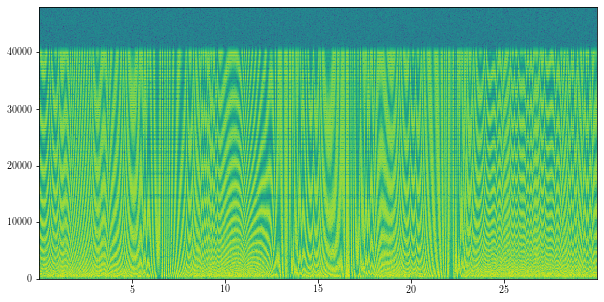

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(times, freq, np.log(Sxx))

In [65]:
# downsample
Sxx_ds = Sxx[5:320, ::downsample_idx]
times_ds = times[::downsample_idx]
freq_ds = freq[5:320]

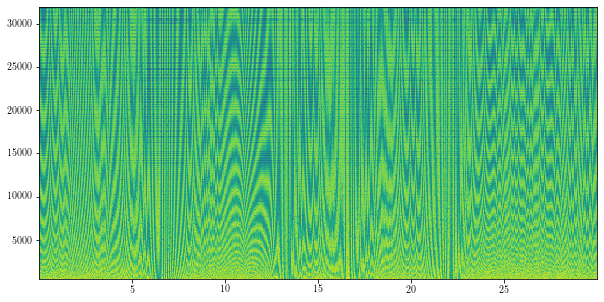

In [66]:
# compare spectrogram after downsampling
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.pcolormesh(times_ds, freq_ds, np.log(Sxx_ds))

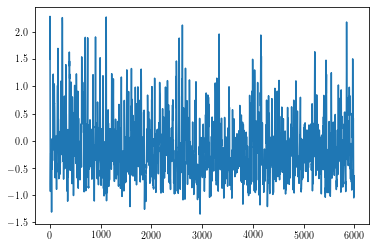

In [68]:
electrode = 53
responses = bnd_resp[2::2]
plt.plot(responses)

# Slice by Slice

In [13]:
coef = np.zeros((n_timepoints_strf_frame, Sxx_ds.shape[0]))

In [14]:
for timepoint in range(n_timepoints_strf_frame):
    rolled = np.roll(Sxx_ds, shift=timepoint, axis=1)
    X = rolled[:, 49:].T
    y = responses[49:]
    
    ridge = LinearRegresion()
    ridge.fit(X, y)
    coef[timepoint] = ridge.coef_

NameError: name 'LinearRegresion' is not defined

(0, 20000)

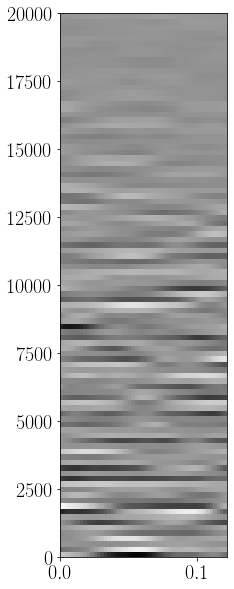

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 10))
ax.pcolormesh(np.arange(0, strf_frame_width, 1 / fs_ecog), freq[:200], np.flip(coef.T, axis=0))
ax.set_ylim([0, 20000])

# full STRF

In [69]:
n_samples = times_ds.size - n_timepoints_strf_frame
n_features = Sxx_ds.shape[0] * n_timepoints_strf_frame

In [70]:
X = np.zeros((n_samples, n_features))
y = np.zeros(n_samples)

In [71]:
for sample in range(n_samples):
    base = sample
    end = base + n_timepoints_strf_frame
    X[sample] = Sxx_ds[:, base:end].ravel()
    y[sample] = responses[n_timepoints_strf_frame + sample]

In [ ]:
ols = LinearRegression()
ols.fit(X, y)

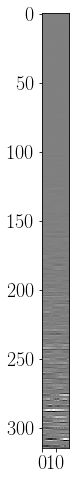

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
coef = ols.coef_.reshape((freq_ds.shape[0], n_timepoints_strf_frame))
ax.imshow(coef, origin='upper')


Text(0, 0.5, '\\textbf{Frequency (Hz)}')

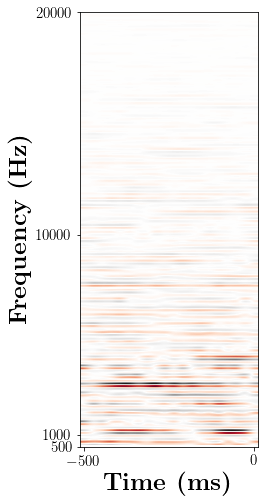

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
coef = ols.coef_.reshape((freq_ds.shape[0], n_timepoints_strf_frame))
ax.imshow(coef, origin='upper', vmax=0.025, vmin=-0.025, cmap=plt.get_cmap('RdGy'), interpolation='spline36')
ax.set_xticks([0, 19])
ax.set_xticklabels([r'$-500$', r'$0$'])
ax.set_xlabel(r'\textbf{Time (ms)}')
ax.set_ylim(top=120)
ax.set_yticks([120, 220, 310, 315])
ax.set_yticklabels([20000, 10000, 1000, 500])
ax.set_aspect(0.25)
ax.tick_params(labelsize=15)
ax.set_ylabel(r'\textbf{Frequency (Hz)}')

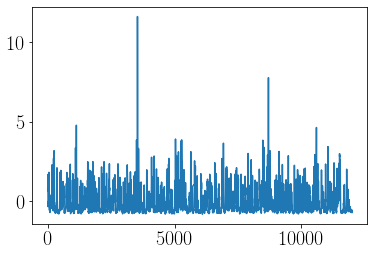

In [55]:
electrode = 114
responses = bnd_resp[electrode, 2::2]
plt.plot(responses)

In [56]:
X2 = np.zeros((n_samples, n_features))
y2 = np.zeros(n_samples)

In [57]:
for sample in range(n_samples):
    base = sample
    end = base + n_timepoints_strf_frame
    X2[sample] = Sxx_ds[:, base:end].ravel()
    y2[sample] = responses[n_timepoints_strf_frame + sample]

In [155]:
ols2 = LinearRegression()
ols2.fit(X2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

(314.5, 100)

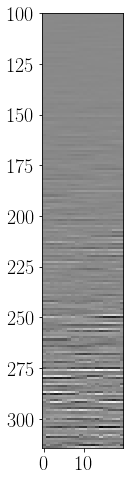

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
coef = ols2.coef_.reshape((freq_ds.shape[0], n_timepoints_strf_frame))
ax.imshow(coef, origin='upper')
ax.set_aspect(0.5)
ax.set_ylim(top=100)

In [157]:
ols2.coef_.min()

-0.016377307229808725

Text(0, 0.5, '\\textbf{Frequency (Hz)}')

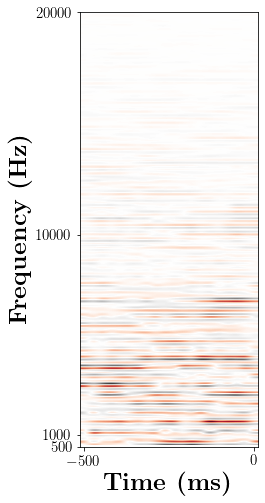

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
coef = ols2.coef_.reshape((freq_ds.shape[0], n_timepoints_strf_frame))
ax.imshow(coef, origin='upper', vmax=0.017, vmin=-0.017, cmap=plt.get_cmap('RdGy'), interpolation='spline36')
ax.set_xticks([0, 19])
ax.set_xticklabels([r'$-500$', r'$0$'])
ax.set_xlabel(r'\textbf{Time (ms)}')
ax.set_ylim(top=120)
ax.set_yticks([120, 220, 310, 315])
ax.set_yticklabels([20000, 10000, 1000, 500])
ax.set_aspect(0.25)
ax.tick_params(labelsize=15)
ax.set_ylabel(r'\textbf{Frequency (Hz)}')